In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import cv2
import IPython.display as ipd
import ipywidgets as widgets
%matplotlib inline

In [2]:
def classify(filename, start, stop, window_length=10240, hop_length=2560):
    """
    Returns frames classified into S_trivial_m, S_trivial_f and S_clean

    Parameter:
    ----------
    :param filename: file URL (xx_SdrChannels)
    :param start: start of audio (in seconds; 0 for minimum)
    :param stop: stop of audio (in seconds; -1 for maximum)
    :param window_length: frame length
    :param hop_length: overlap of frames (ideally: window_length / int)
    :return: (S_trivial_m, S_trivial_f, S_clean), with each of the form: [[y, y_f, y_m],...,[y', y_f', y_m']],
        where y = mic, y_f = female acc, y_m = male_acc are amplitude values of one vocalization frame
    """

    # Import audio -----------------------------------------------------------------------------------------------------
    sampling_rate = 24000

    start = start * sampling_rate
    stop = stop * sampling_rate if stop > 0 else -1
    
#audio= what i would get from simons data (from the sdr data)
    audio, sampling_rate = sf.read(filename, start=start, stop=stop)

    lim = math.floor(len(audio) / window_length) * window_length    # ensures full "framization" of sequence
    channels = {
        "mic": audio[:lim, 0],
        "female": audio[:lim, 1],
        "male": audio[:lim, 2]
    }

    mic = channels["mic"]
    female = channels["female"]
    male = channels["male"]
    time = np.arange(len(mic)) / sampling_rate    # in seconds

    # Local Regression (eliminate offset) ------------------------------------------------------------------------------
    signal = []
    length = 10000  # interpolation frame length
    model = LinearRegression()
    transformer = PolynomialFeatures(3)     # polynomial interpolation of order 3
    for i in range(0, len(mic), length):
        t = time[i:i + length]
        X = transformer.fit_transform(t.reshape(-1, 1))
        y = mic[i:i + length]
        model.fit(X, y)
        signal.append(model.predict(X))
    mic = mic - [item for items in signal for item in items]

    # Features ---------------------------------------------------------------------------------------------------------
    energy = 200 * librosa.feature.rms(np.asfortranarray(mic), center=False,
                                       frame_length=window_length, hop_length=hop_length)[0] ** 2

    # Signal detection  ------------------------------------------------------------------------------------------------
    frames = [[i, i + window_length] for i in range(0, len(mic) - window_length + 1, hop_length)]
    labels = ["" for i in range(len(energy))]   # class of each frame

    threshold_silence = 0.005
    threshold_signal_lower = 0.07
    threshold_signal_upper = 0.3
    for i, value in enumerate(energy):
        if value < threshold_silence:
            labels[i] = "silence"
        elif threshold_signal_lower < value < threshold_signal_upper:
            labels[i] = "signal"
        else:
            labels[i] = "not classified"

    samples = {}    # samples[index of audio file] = corresponding class
    for label in ["not classified", "silence", "signal"]:
        for i, frame in enumerate(frames):
            if labels[i] == label:
                for t in range(frame[0], frame[1]):
                    samples[t] = label

    # Reorder frames (connect overlapping frames) ----------------------------------------------------------------------
    #list of indices from t
    #2 sec = 20k indices. in the array the indices of the samples which are labeled as either silence or signal (200:500)
    #i get start and end values of these samples. 
    
    signal = []
    
    frame = []
    for t in sorted(samples.keys()):
        label = samples[t]
        if label == "signal":
            frame.append(t)
        else:
            signal.append(frame) if len(frame) != 0 else None
            frame = []
    
   # frame = []
    #silence= []
            #copy this:
    #for t in sorted(samples.keys()):
        #label = samples[t]
        #if label == "signal": #put ="silence"
            #frame.append(t)
        #else:
           # signal.append(frame) if len(frame) != 0 else None
            #frame = []

    # Clustering -------------------------------------------------------------------------------------------------------
    sr = sampling_rate
    
    def radio(m, f): 
        spec_flatness_f = 100 * np.average(librosa.feature.spectral_flatness(np.asfortranarray(f))) # percentage
        spec_flatness_m = 100 * np.average(librosa.feature.spectral_flatness(np.asfortranarray(m))) # percentage
        
        return True if (spec_flatness_m > 30 or spec_flatness_f > 30) else False # only filters out radio noise
    
    def vocalizer(m, f):
        # mel
        S = librosa.feature.melspectrogram(y=np.asfortranarray(m), sr=sr, n_mels=64, fmin=300, fmax=2000)
        m = librosa.power_to_db(S, ref=np.max)

        S = librosa.feature.melspectrogram(y=np.asfortranarray(f), sr=sr, n_mels=64, fmin=0, fmax=3000)
        f = librosa.power_to_db(S, ref=np.max)

        # image analysis
        img_m = np.asarray(m, dtype=np.uint8)
        img_f = np.asarray(f, dtype=np.uint8)

        # yellow analysis (spectral energy in freq interval)
        yellow = np.average([np.average(list) for list in img_m])
        voc_m = 210 < np.average([np.average(list) for list in img_m]) < 250
        voc_f = 210 < np.average([np.average(list) for list in img_f]) < 250

        # spectral complexity analysis
        a, b = np.shape(img_m) # same for img_f
        imgs = [img_m, img_f]
        perimeters = [0, 0]

        for j, img in enumerate(imgs):
            # accentuate complexity
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            ret, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
            img = cv2.GaussianBlur(img, (7,7), 0)
            ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
            img = cv2.Canny(img, 100, 200)

            perimeter = np.count_nonzero(img != 0)
            perimeters[j] = 100 * perimeter / (2 * (a + b))

        voc_m = (perimeters[0] > 90) and voc_m
        voc_f = (perimeters[1] > 90) and voc_f
    
        return voc_m, voc_f
    
    S_trivial_m = []    # only male vocalizes
    S_trivial_f = []    # only female vocalizes
    S_clean = []        # both vocalize
    
    for frame in signal:
        t = np.asarray(frame) #y-mic
        y, y_f, y_m = [mic[x] for x in t], [female[x] for x in t], [male[x] for x in t]
        
        if not radio(y_m, y_f): # make sure has no noise
            m_, f_ = vocalizer(y_m, y_f)
            if m_ and f_:
                S_clean.append([y, y_f, y_m, t]) # both so basically added t to the amplitue data
            elif m_:
                S_trivial_m.append([y, y_f, y_m, t]) # only male
            elif f_:
                S_trivial_f.append([y, y_f, y_m, t]) # only female
            else:
                None    # none
    
    return S_trivial_m, S_trivial_f, S_clean
#male vocalizes and female is silent = s_trivial m. 
#female vocalizes and male is silent = s_trivial f
#both vocalize at he same time = s_clean


In [8]:
# USER:
number = 53
filename = "/Volumes/Drive/ETH/Neural_Systems/b8p2male-b10o15female_aligned/2018-08-19/b8p2male-b10o15female_53_SdrChannels.w64"
S_trivial_m, S_trivial_f, S_clean = classify(filename, 0, -1)

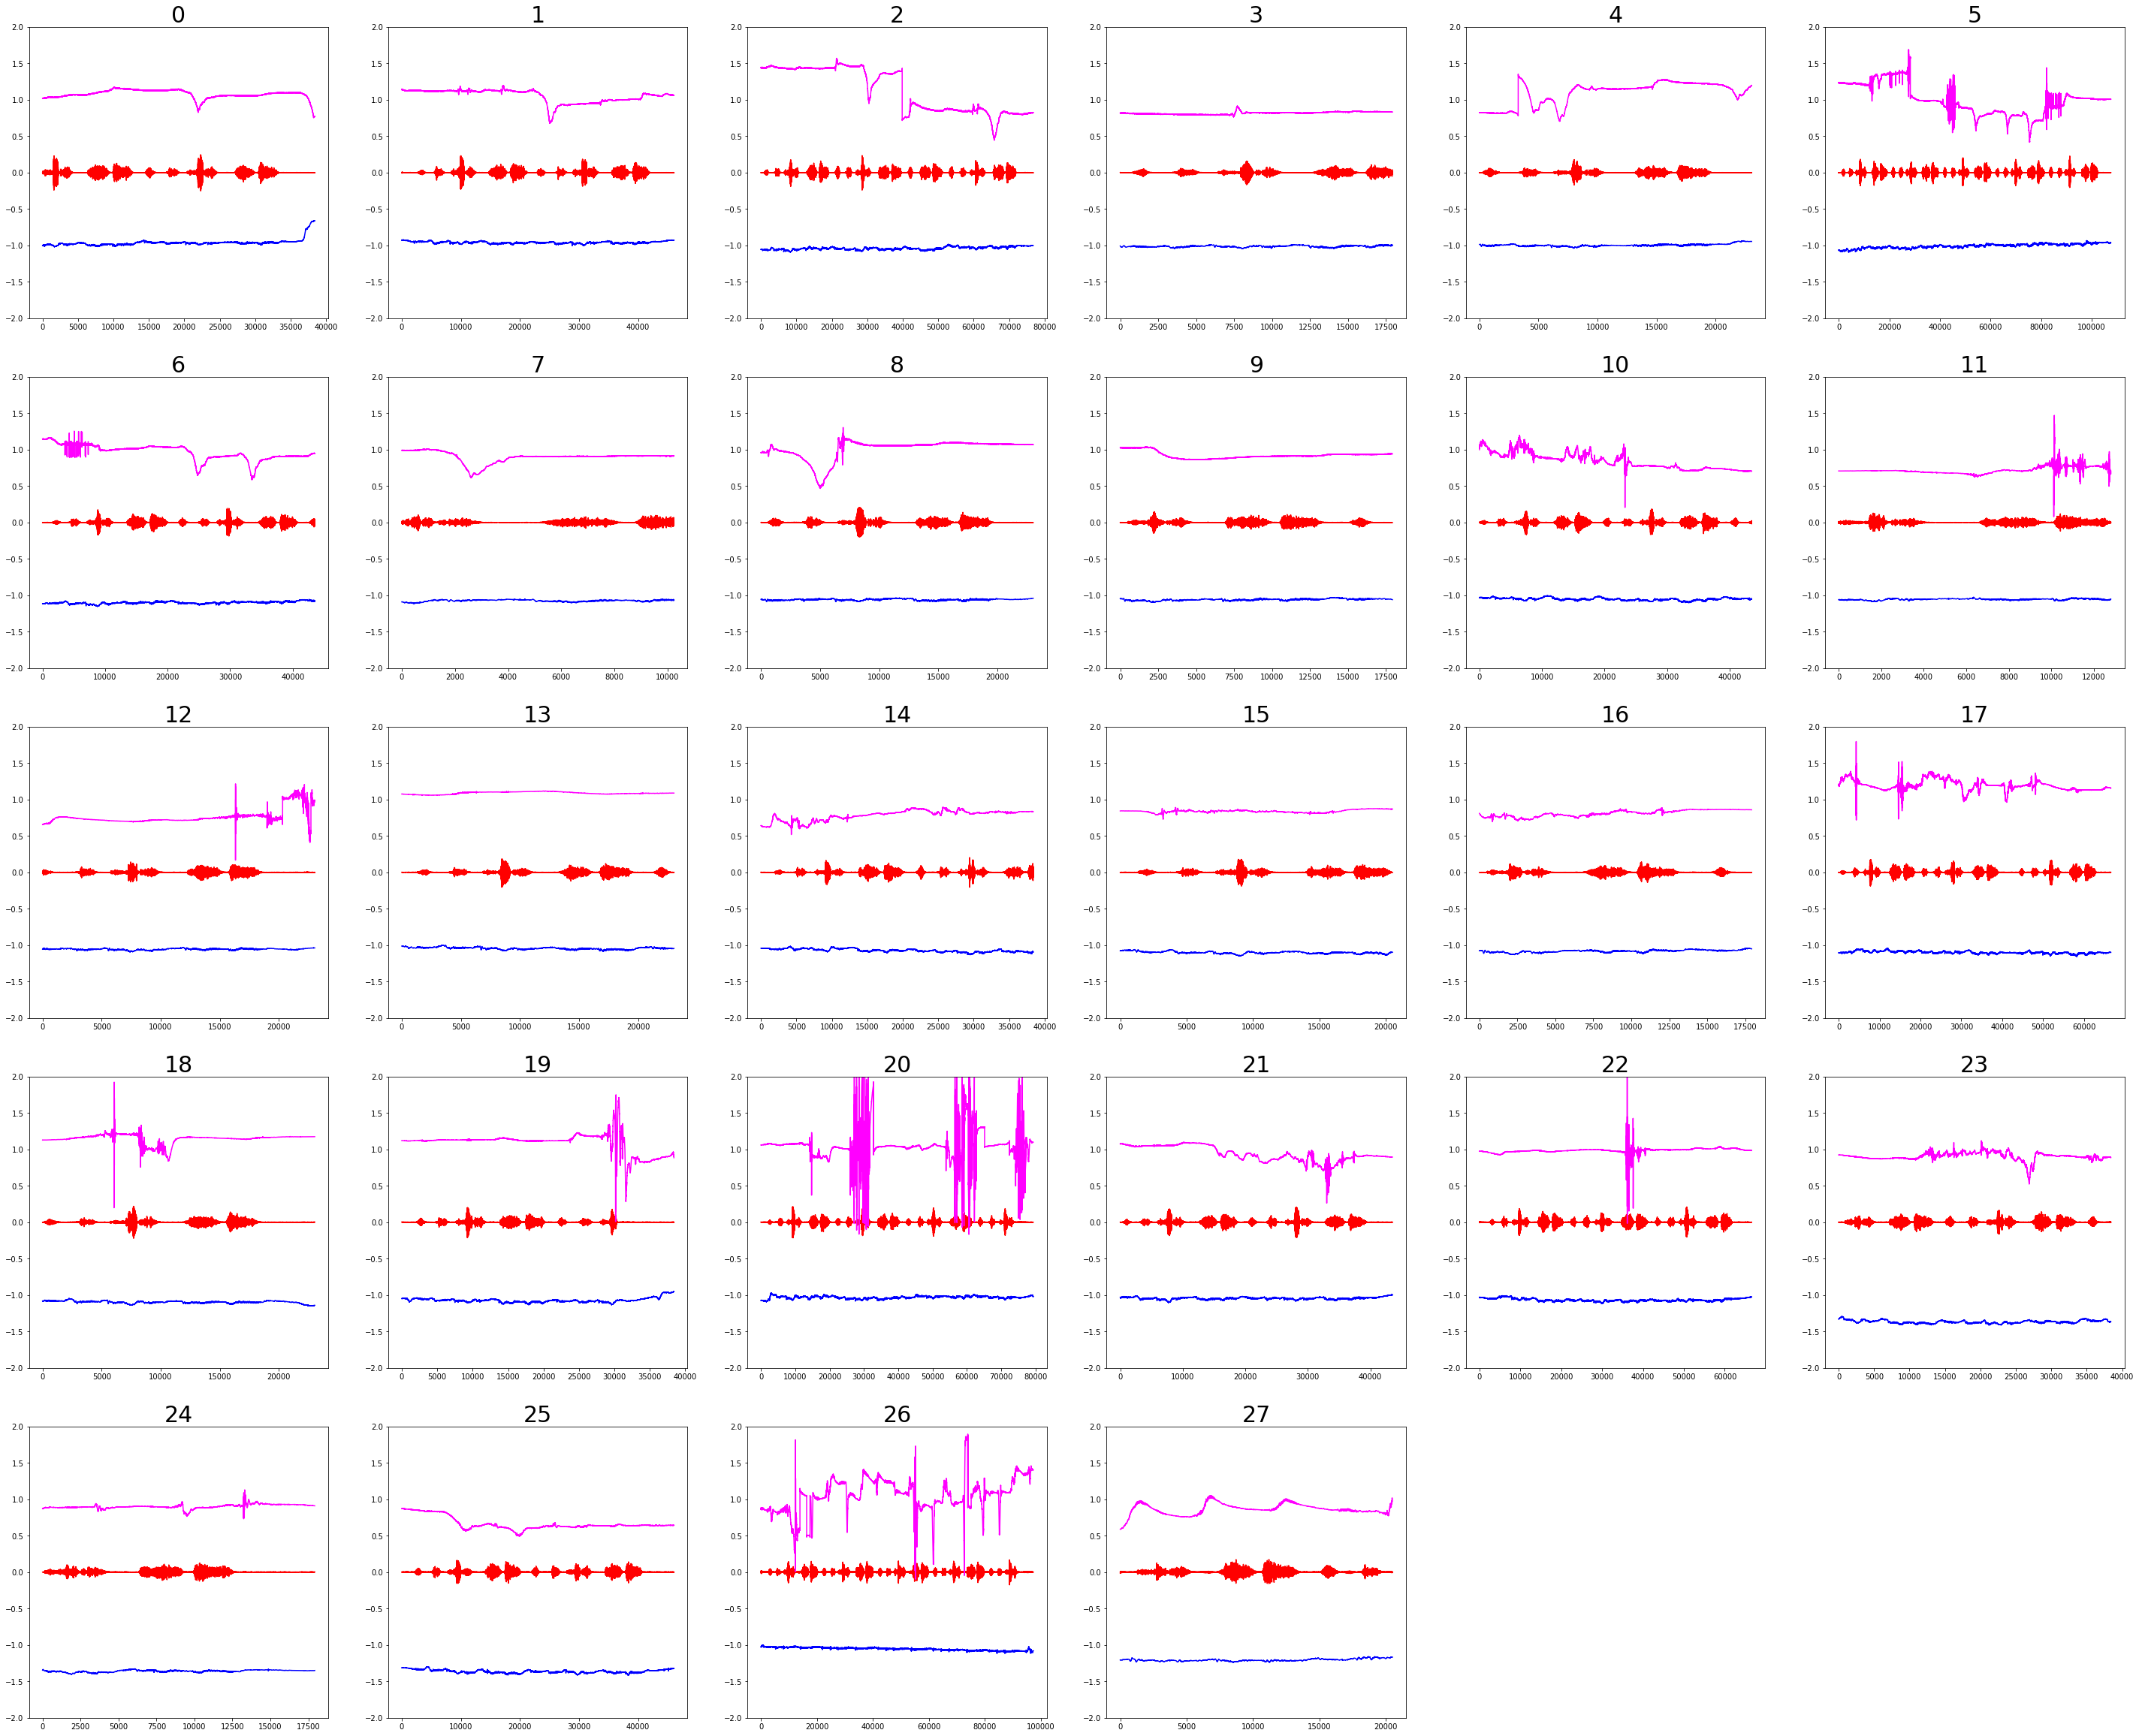

In [9]:
# Plot S_trivial_m
plt.figure(figsize=(50, 50))
n = math.ceil(np.sqrt(len([0 for frame in S_trivial_m])))
for i, frame in enumerate(S_trivial_m):
    mic = frame[0]
    female = [value + 1 for value in frame[1]]
    male = [value - 1 for value in frame[2]]

    ax = plt.subplot(n, n, i + 1)
    plt.ylim(-2, 2)
    plt.title(i, fontsize=30)
    plt.plot(mic, "red")
    # female
    plt.plot(female, "magenta")
    # male
    plt.plot(male, "blue")
plt.show()

In [10]:
# Plot S_trivial_f
plt.figure(figsize=(50, 50))
n = math.ceil(np.sqrt(len([0 for frame in S_trivial_f])))
for i, frame in enumerate(S_trivial_f):
    mic = frame[0]
    female = [value + 1 for value in frame[1]]
    male = [value - 1 for value in frame[2]]

    ax = plt.subplot(n, n, i + 1)
    plt.ylim(-2, 2)
    plt.title(i, fontsize=30)
    plt.plot(mic, "red")
    # female
    plt.plot(female, "magenta")
    # male
    plt.plot(male, "blue")
plt.show()

<Figure size 3600x3600 with 0 Axes>

In [11]:
# Plot S_clean
plt.figure(figsize=(50, 50))
n = math.ceil(np.sqrt(len([0 for frame in S_clean])))
for i, frame in enumerate(S_clean):
    mic = frame[0]
    female = [value + 1 for value in frame[1]]
    male = [value - 1 for value in frame[2]]

    ax = plt.subplot(n, n, i + 1)
    plt.ylim(-2, 2)
    plt.title(i, fontsize=30)
    plt.plot(mic, "red")
    # female
    plt.plot(female, "magenta")
    # male
    plt.plot(male, "blue")
plt.show()

<Figure size 3600x3600 with 0 Axes>

In [12]:
# Choose frame in S_trivial_m
signal = S_trivial_m
print("n_signals: ", len([0 for frame in signal]))

play_frame = 2
dropdown = widgets.Dropdown(options=[(str(i), i) for i in range(len(signal))], values=2, description="Frame:")
display(dropdown)

n_signals:  28


Dropdown(description='Frame:', options=(('0', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6), …

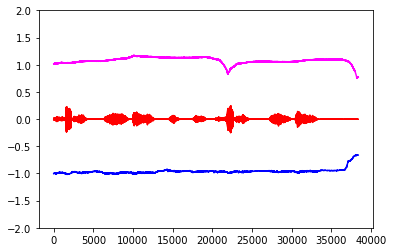

mic


In [13]:
# Listen
sampling_rate = 24000
y = signal[dropdown.value][0]
y_f = [value + 1 for value in signal[dropdown.value][1]]
y_m = [value - 1 for value in signal[dropdown.value][2]]

plt.figure()
plt.ylim(-2, 2)
plt.plot(y, "red")
# female
plt.plot(y_f, "magenta")
# male
plt.plot(y_m, "blue")
plt.show()
 
print("mic")
ipd.Audio(y, rate=sampling_rate)

In [14]:
print("female")
ipd.Audio(y_f, rate=sampling_rate)

female


In [15]:
print("male")
ipd.Audio(y_m, rate=sampling_rate)

male
